In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [6]:
!conda create -n my_environment -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/rkaranj/.conda/envs/my_environment



Preparing transaction: done
Verifying transaction: done
Executing transaction: done
#
# To activate this environment, use
#
#     $ conda activate my_environment
#
# To deactivate an active environment, use
#
#     $ conda deactivate



In [10]:
!source activate my_environment

In [11]:
pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.3 MB 4.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [42]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    print((width_factor, height_factor, depth_factor))
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    print(img.shape)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    #Resize width, height and depth
    volume = resize_volume(volume)
    
    return volume

In [22]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join("No", x)
    for x in os.listdir("No")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join("./Yes", x)
    for x in os.listdir("Yes")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 619
CT scans with abnormal lung tissue: 692


#### Process Abnormal Scans

In [24]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])

#### Process Normal Scans

In [25]:
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
print(2)

2


#### Assign 1 or 0

In [26]:
# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
print(3)
normal_labels = np.array([0 for _ in range(len(normal_scans))])
print(4)

3
4


#### Split data 70-30

In [27]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:550], normal_scans[:550]), axis=0)
print(5)
y_train = np.concatenate((abnormal_labels[:550], normal_labels[:550]), axis=0)
print(6)
x_val = np.concatenate((abnormal_scans[550:], normal_scans[550:]), axis=0)
print(7)
y_val = np.concatenate((abnormal_labels[550:], normal_labels[550:]), axis=0)
print(8)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

5
6
7
8
Number of samples in train and validation are 1100 and 211.


In [28]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [0]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
#     volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [29]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 24
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


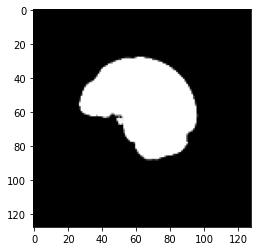

In [30]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

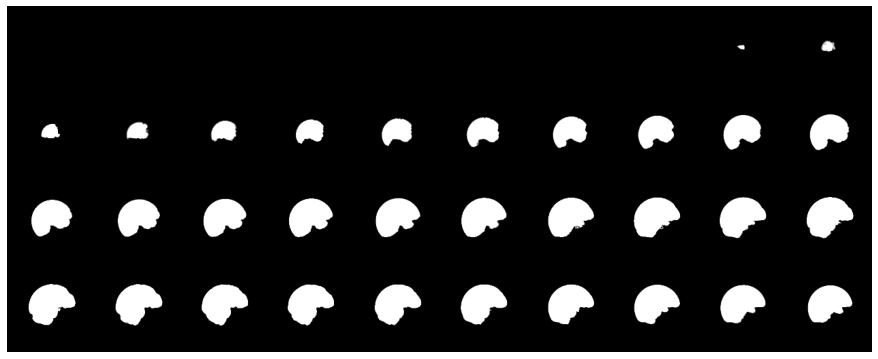

In [31]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [72]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_9 (Conv3D)           (None, 126, 126, 62, 16)  448       
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 63, 63, 31, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 63, 63, 31, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_10 (Conv3D)          (None, 61, 61, 29, 32)    13856     
                                                             

In [73]:
# Compile model.
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_relu.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
46/46 [==============================] - 10s 195ms/step - loss: 0.6465 - acc: 0.6918 - val_loss: 0.7142 - val_acc: 0.3270
Epoch 2/100
46/46 [==============================] - 10s 211ms/step - loss: 0.4968 - acc: 0.9845 - val_loss: 0.7484 - val_acc: 0.3270
Epoch 3/100
46/46 [==============================] - 9s 191ms/step - loss: 0.3823 - acc: 0.9873 - val_loss: 0.7759 - val_acc: 0.3270
Epoch 4/100
46/46 [==============================] - 9s 191ms/step - loss: 0.3188 - acc: 0.9836 - val_loss: 0.7812 - val_acc: 0.3270
Epoch 5/100
46/46 [==============================] - 9s 191ms/step - loss: 0.2774 - acc: 0.9855 - val_loss: 0.7449 - val_acc: 0.3270
Epoch 6/100
46/46 [==============================] - 9s 192ms/step - loss: 0.2335 - acc: 0.9900 - val_loss: 0.6822 - val_acc: 0.3318
Epoch 7/100
46/46 [==============================] - 9s 193ms/step - loss: 0.2164 - acc: 0.9864 - val_loss: 0.5927 - val_acc: 0.9573
Epoch 8/100
46/46 [==============================] - 9s 192ms/step 

KeyError: 'acc'

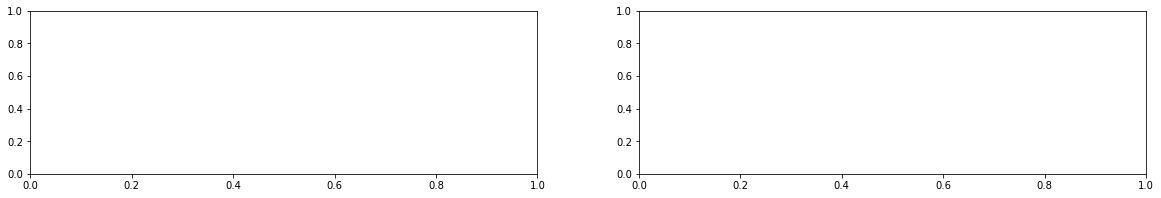

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Predict with a image

In [81]:
file = process_scan('Yes/IXI002-Guys-0828-T1_bse_less_s5_r1.nii.gz')
file = tf.expand_dims(file, axis=0)

prediction = model.predict(file)


yes,no = prediction[0] * 100, (1-prediction[0]) *100

print("Yes=",yes[0],"No=",no[0])
if(yes[0]>50):
    print("Facial Feature Recognizable")
else:
    print("Facial Feature not recognizable")

(0.5, 0.5, 0.4266666666666667)
(128, 128, 64)
Yes= 95.087006 No= 4.9129963
Facial Feature Recognizable
